In [1]:
import os

initial_data = {}

def read_files_in_directory(directory):
    coord_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            coords = []
            file_path = os.path.join(root, file)
            # Check if it's a text file (you can adjust this)
            if file.endswith('.txt'):
                with open(file_path, 'r') as f:
                    content = f.readlines()
                    for i in content:
                        xy = i.split()
                        coords.append((int(xy[0]), int(xy[1])))
            coord_list.append(coords)

            initial_data[directory[-1::]] = coord_list

def iterate_directories(directory):
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            print(f"Directory: {dir_path}")
            read_files_in_directory(dir_path)

iterate_directories('./train')

# print(initial_data)

Directory: ./train/ഘ
Directory: ./train/ക
Directory: ./train/ങ
Directory: ./train/ഖ
Directory: ./train/ഗ


/tmp/ipykernel_1762788/698726291.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


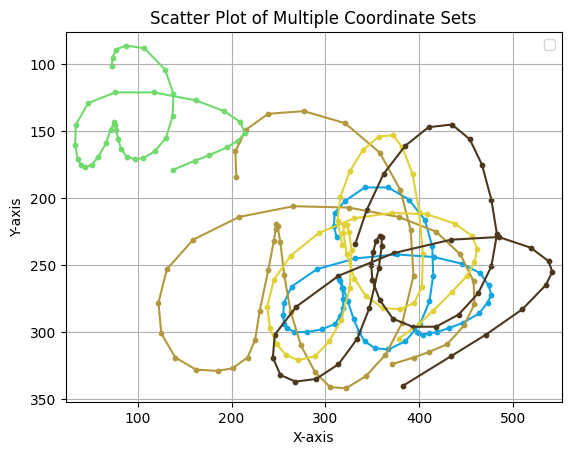

In [2]:
import matplotlib.pyplot as plt
import random

def plot_letters(coordinates_list):

    x_list = []
    y_list = []
    
    for c in coordinates_list:
        x, y = zip(*c)
        x_list.append(x)
        y_list.append(y)

    plt.xlim(min(x_list[0]), max(x_list[0]))
    plt.ylim(min(y_list[0]), max(y_list[0]))

    for x, y in zip(x_list, y_list):
        color = (random.random(), random.random(), random.random())
        plt.scatter(x, y, color=color, s=10)  # First set in blue
        plt.plot(x, y, color=color, linestyle='-', marker='o', markersize=1)
    
        plt.xlim(min(min(x), plt.xlim()[0] + 10) - 10, max(max(x), plt.xlim()[1] - 10) + 10)
        plt.ylim(min(min(y), plt.ylim()[0] + 10) - 10, max(max(y), plt.ylim()[1] - 10) + 10)
    
    # Invert y-axis if needed
    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    
    # Add titles and labels
    plt.title('Scatter Plot of Multiple Coordinate Sets')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    # Show grid
    plt.grid()
    
    # Add a legend
    plt.legend()
    
    # Display the plot
    plt.show()

plot_letters(initial_data['ക'][10:15])

In [3]:
def normalize_coordinates(coordinates):
    x_list, y_list = zip(*coordinates)
    x_min = min(x_list)
    y_min = min(y_list)

    x_max = max(x_list)
    y_max = max(y_list)

    n_range = 100

    x_range = x_max - x_min
    y_range = y_max - y_min

    n_factor_x = x_range / n_range
    n_factor_y = y_range / n_range

    n_factor = n_factor_x
    
    if y_range > x_range:
        n_factor = n_factor_y

    n_min_x = int(x_min / n_factor)
    n_min_y = int(y_min / n_factor)

    normalized_coordinates = []

    for c in coordinates:
        p = (int(c[0] / n_factor) - n_min_x, int(c[1] / n_factor) - n_min_y)
        normalized_coordinates.append(p)

    return normalized_coordinates

# for i in initial_data['ഘ']:
    # plot_letters([normalize_coordinates(i)])
    # print(i)
#     print(normalize_coordinates(i))

In [4]:
!pip install rdp


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


/tmp/ipykernel_1762788/698726291.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


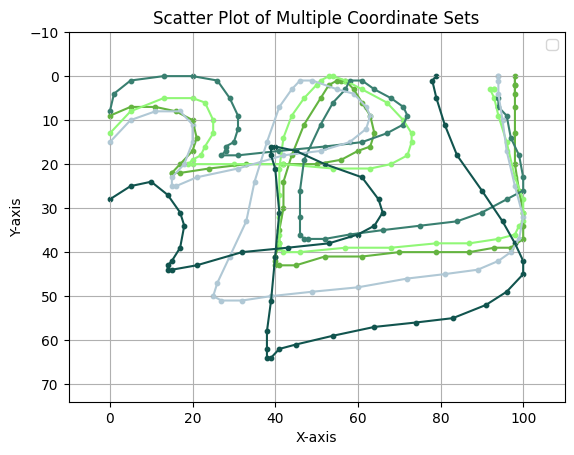

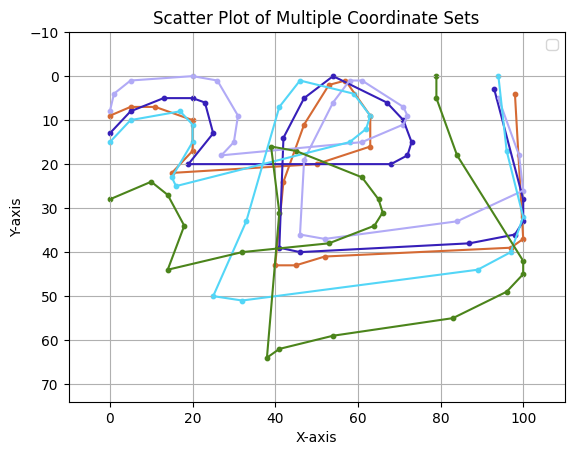

In [23]:
import numpy as np
from rdp import rdp

normalized_coordinates_list = []
normalized_reduced_coordinates_list = []

for c in initial_data['ഘ'][70:75]:
    normalized_coordinates_list.append(normalize_coordinates(c))
    normalized_reduced_coordinates_list.append(rdp(np.array(normalized_coordinates_list[-1]), epsilon=1))

plot_letters(normalized_coordinates_list)
plot_letters(normalized_reduced_coordinates_list)

In [5]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical

# # Example data
# sequences = np.random.rand(1000, 10, 2)  # 1000 samples, 10 timesteps, 2 features (x, y)
# labels = np.random.randint(0, 5, size=(1000,))  # Random labels for 5 classes

# # Normalize x, y coordinates
# # sequences = (sequences - np.mean(sequences, axis=0)) / np.std(sequences, axis=0)

# # Encode labels
# encoder = LabelEncoder()
# encoded_labels = encoder.fit_transform(labels)
# categorical_labels = to_categorical(encoded_labels, num_classes=5)


# print(sequences)
# print(encoded_labels)
# print(categorical_labels)

In [6]:
sequences = []
labels = []

for i in initial_data.keys():
    sequences += initial_data[i]
    labels += [i] * len(initial_data[i])

normalized_sequences = []
for coordinates in sequences:
    normalized_sequences.append(normalize_coordinates(coordinates))

# for i, j in zip(labels, normalized_sequences):
#     print(i, j[-10:])

In [ ]:
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np

seq_lens = [len(i) for i in normalized_sequences]
dimension = 2
print(seq_lens)    

special_value = -10.0
max_seq_len = max(seq_lens)

np_normalized_sequences = np.asarray(normalized_sequences, dtype="object")

# print(np_normalized_sequences)

Xpad = np.full((len(np_normalized_sequences), max_seq_len, dimension), fill_value=special_value)
for s, x in enumerate(np_normalized_sequences):
    seq_len = np.shape(x)[0]
    Xpad[s, 0:seq_len, :] = x

print(Xpad)

model2 = Sequential()
model2.add(Masking(mask_value=special_value, input_shape=(max_seq_len, dimension)))
model2.add(LSTM(lstm_units))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model2.summary())
model2.fit(Xpad, y, epochs=50, batch_size=32)

2024-10-29 13:07:41.324321: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 13:07:41.691816: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Parameters
N = 1000
halfN = int(N/2)
dimension = 2
lstm_units = 3

np.random.seed(123)  # to generate the same numbers
# create sequence lengths between 1 to 10
seq_lens = np.random.randint(1, 10, halfN)
X_zero = np.array([np.random.normal(0, 1, size=(seq_len, dimension)) for seq_len in seq_lens], dtype="object")
y_zero = np.zeros((halfN, 1))
X_one = np.array([np.random.normal(1, 1, size=(seq_len, dimension)) for seq_len in seq_lens], dtype="object")
y_one = np.ones((halfN, 1))
p = np.random.permutation(N)  # to shuffle zero and one classes
X = np.concatenate((X_zero, X_one))[p]
Y = np.concatenate((y_zero, y_one))[p]

In [4]:
import pyrdp
from pyrdp import rdp


ModuleNotFoundError: No module named 'pyrdp'